## [E09] 폐렴 X-ray 이미지 양성 음성구분 프로젝트

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
import random as python_random

warnings.filterwarnings(action='ignore')


In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print("train 데이터셋 파일 개수:",len(train_filenames))
print("test 데이터셋 파일 개수:",len(test_filenames))
print("validation 데이터셋 파일 개수",len(val_filenames))
total_train=len(train_filenames)+len(test_filenames)+len(val_filenames)

train 데이터셋 파일 개수: 5216
test 데이터셋 파일 개수: 624
validation 데이터셋 파일 개수 16


In [4]:
# tf.io.gfile.glob를 사용해서 train 폴더 안에 있는 모든 파일의 path가 리스트 형태로 담긴다.
 
print(train_filenames[:4])
type(train_filenames) 

['/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1332-0001.jpeg', '/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0176-0001.jpeg', '/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1011-0001.jpeg', '/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0375-0001.jpeg']


list

In [5]:
print("train 데이터셋 파일 비율: ",len(train_filenames)/total_train)
print("test 데이터셋 파일 비율: ",len(test_filenames)/total_train)
print("val 데이터셋 파일 비율: ",len(val_filenames)/total_train)

train 데이터셋 파일 비율:  0.8907103825136612
test 데이터셋 파일 비율:  0.10655737704918032
val 데이터셋 파일 비율:  0.00273224043715847


train 데이터셋의 비율은 89.07%, test 데이터셋의 비율은 10.65%, val 데이터셋의 비율은 0.27%에 해당한다. validation 데이터셋 양이 너무 적어서 train 데이터셋과 validation 데이터셋을 다시 나누자

In [6]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_size = math.floor(len(filenames)*0.8) # train 데이터 사이즈

random.seed(8)  # random seed 셋팅
random.shuffle(filenames) # filenames의 순서를 섞는다

# 모아진 filenames를 8:2로 나눕니다
train_filenames = filenames[:train_size] # traindata
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


경로에 NORMAL이 포함되어 있으면 폐암 아니고, 경로에 PNEUMONIA가 포함 되어있으면 폐암.

In [7]:
print(f'Normal image path\n{filenames[0]}') 
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


train 데이터셋의 정상 폐 이미지는 1072개, 폐암 이미지는 3113개이다.

In [8]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


리스트 형태의 데이터를 tf.data.Dataset.from_tensor_slices를 사용해서 텐서플로에서 사용하는 데이터셋으로 만들어준다.

In [9]:
data=tf.data.Dataset.from_tensor_slices(train_filenames[:10]) # element가 10개인 데이터를 입력해서 
print(type(data))
print(data)

<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<TensorSliceDataset shapes: (), types: tf.string>


data에 크기가 1인 텐서 10개가 할당되었다. 

In [10]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [11]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy() # training image
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()  # validatiion image
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [12]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [13]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출( 폐렴 True, 정상 False)
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [14]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [15]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [16]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [17]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

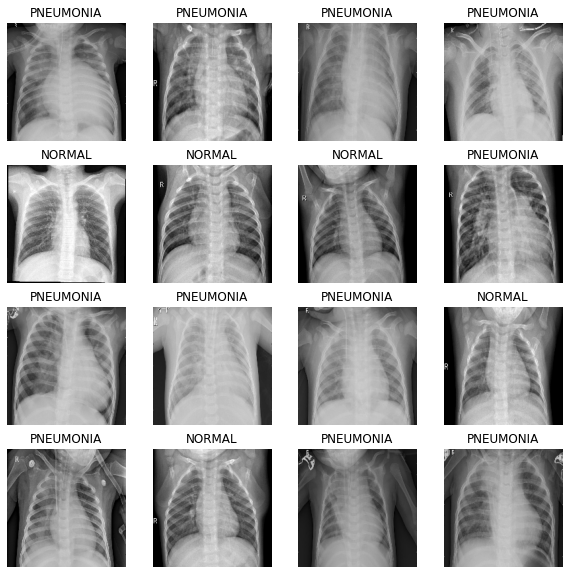

In [18]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### CNN 모델링
- CS231에서 uniform한 분포에서 난수를 뽑아오는 것보다는 가우시안 분포 (정규분포)에서 난수를 뽑아서 초기 weight을 설정하는 것이 좋다길래 각 레이어의 kernel_initializer를 glorot_normal(xavier initializer-정규분포)로 바꿔주었다. 케라스의 kernel_initializer의 기본값은 [glorot_uniform(xavier initializer- uniform분포)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)이다. 그래서 정규분포에서 난수를 뽑아오는 설정을 추가해주어보았다.

In [19]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same',kernel_initializer=tf.keras.initializers.glorot_normal(seed=1)),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same',kernel_initializer=tf.keras.initializers.glorot_normal(seed=2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [20]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [21]:
def build_model(filter1=16, kernel_size1=3, filter2=16, kernel_size2=3, dropout1=0.2, dropout2=0.2):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(filter1, kernel_size1, activation='relu', padding='same',kernel_initializer=tf.keras.initializers.glorot_normal(seed=4)),
        tf.keras.layers.Conv2D(filter2, kernel_size2, activation='relu', padding='same',kernel_initializer=tf.keras.initializers.glorot_normal(seed=5)),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(dropout1),
        
        conv_block(256),
        tf.keras.layers.Dropout(dropout2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 00. learning rate 
- learning rate를 $10^{-2},10^{-3},10^{-4},10^{-5}$를 시도해보았다. 
- 처음에 그냥 모델을 주어진대로 돌려보니까 loss가 줄었다 늘었다를 반복해서 learning rate를 안정적으로 학습시켜보고 싶어서 learning rate를 크게 줄여가면서 돌려보았다.

In [22]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [33]:
EPOCHS=25

# my_callbacks = [
#    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
#    tf.keras.callbacks.TensorBoard(log_dir='./logs'),]
metrics_lr=[]
for lr in [0.01,0.001, 0.0001, 0.00001]:
    with tf.device('/GPU:0'):
        model = build_model(filter1=16, kernel_size1=3, filter2=16, kernel_size2=3, dropout1=0.2, dropout2=0.2)

        METRICS = [
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
    
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss='binary_crossentropy',
            metrics=METRICS)
        history = model.fit(
            train_ds,
            steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=val_ds,
            validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
            class_weight=class_weight,)
#            callbacks=my_callbacks)
        metrics_lr.append(history)

Epoch 1/25
261/261 [==============================] - 62s 201ms/step - loss: 0.4346 - accuracy: 0.7986 - precision: 0.9328 - recall: 0.7860 - val_loss: 0.4432 - val_accuracy: 0.8346 - val_precision: 0.8190 - val_recall: 0.9948
Epoch 2/25
261/261 [==============================] - 54s 206ms/step - loss: 0.2376 - accuracy: 0.9028 - precision: 0.9704 - recall: 0.8966 - val_loss: 3.1054 - val_accuracy: 0.3760 - val_precision: 1.0000 - val_recall: 0.1516
Epoch 3/25
261/261 [==============================] - 53s 205ms/step - loss: 0.2226 - accuracy: 0.9138 - precision: 0.9738 - recall: 0.9087 - val_loss: 0.1572 - val_accuracy: 0.9394 - val_precision: 0.9916 - val_recall: 0.9254
Epoch 4/25
261/261 [==============================] - 55s 210ms/step - loss: 0.2052 - accuracy: 0.9140 - precision: 0.9761 - recall: 0.9066 - val_loss: 0.5255 - val_accuracy: 0.8529 - val_precision: 0.9952 - val_recall: 0.8042
Epoch 5/25
261/261 [==============================] - 54s 206ms/step - loss: 0.1839 - accura

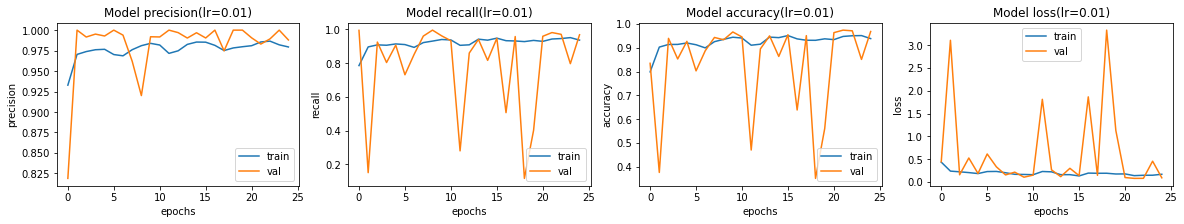

In [34]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()
history=metrics_lr[0]
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}(lr=0.01)'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

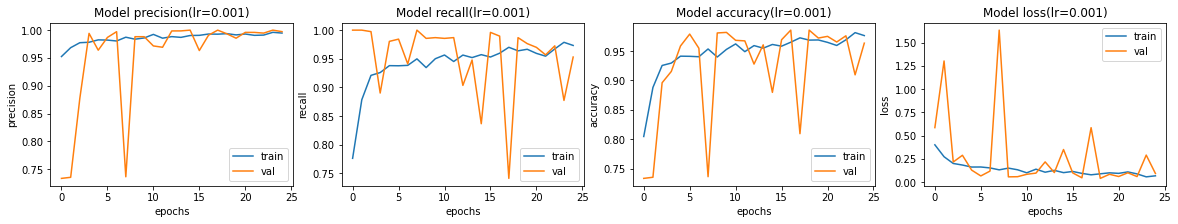

In [35]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()
history=metrics_lr[1]
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}(lr=0.001)'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

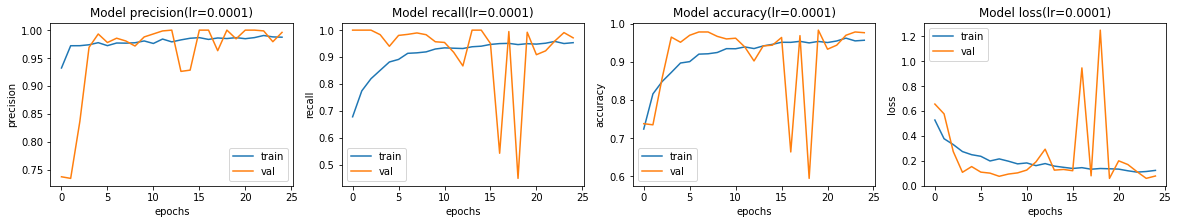

In [36]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()
history=metrics_lr[2]
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}(lr=0.0001)'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

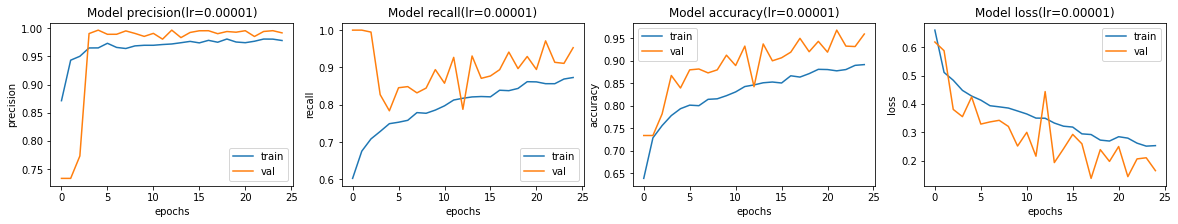

In [37]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()
history=metrics_lr[3]
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}(lr=0.00001)'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

- learning rate가 0.01, 0.001, 0.0001, 0.00001 이렇게 4가지에 대해서 돌려보았다. epoch이 증가하면 loss는 감소하고, accuracy, recall, precision은 증가한다. 
- 우리가 분류해내려고 하는 데이터는 normal이 극단적으로 많고, pneumonia가 매우 적은 데이터이다. inbalanced 데이터이기 때문에  class weight을 NORMAL은 1.95, PNEUMONIA은 0.67으로 주었다. 그래서 normal을 조금 많이 틀려도 loss가 급격하게 증가하게 되어서 4가지 그래프의 loss의 학습곡선이 들쑥날쑥한 것을 볼수 있다.  
- learning rate가 0.01과 0.001일때의 loss 그래프를 보면 epoch 초기부터 갑자기 loss가 증가하는 것을 볼수 있다. 아마도 learning rate가 너무 커서 오버슈팅일 일어나기 때문인것 같다.
- learning rate가 0.00001인 경우는 다른 learning rate에 비해서 loss가 안정적으로 줄어들지만, loss가 너무 천천히 떨어지게 되는 모습을 볼수 있다. learning rate가 지나치게 작아서 학습이 지나치게 적게 이루어진다는 확인했다.

-----------------------

- __learning rate가 0.0001일때 상대적으로 loss가 안정적으로 감소하고, accuracy와 recall, precision도 높은 편이다.__  비록 epoch이 15번 넘어가면서 2번정도 갑자기 loss가 증가하는 것을 볼수 있지만 뒤에서 check point에서 validation loss를 확인하고 피해가면 되는 정도라고 생각해서 __learning rate를 0.0001로 잡고 학습__ 을 해야겠다.

### epoch 
- 일단 50까지 쭉 돌려보고, epoch가 얼마나 많이 학습하게되면 overfitting이 일어나는지 그 구간을 찾아보자

In [40]:
#my_callbacks = [
#    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
#    tf.keras.callbacks.TensorBoard(log_dir='./logs'),]
EPOCHS=100
metrics_lr=[]
for lr in [0.0001]:
    with tf.device('/GPU:0'):
        model = build_model(filter1=16, kernel_size1=3, filter2=16, kernel_size2=3, dropout1=0.2, dropout2=0.2)

        METRICS = [
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
    
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss='binary_crossentropy',
            metrics=METRICS)
        history = model.fit(
            train_ds,
            steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=val_ds,
            validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
            class_weight=class_weight,)
#            callbacks=my_callbacks)
        metrics_lr.append(history)

Epoch 1/100
261/261 [==============================] - 59s 191ms/step - loss: 0.4900 - accuracy: 0.7708 - precision: 0.9313 - recall: 0.7469 - val_loss: 0.6078 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/100
261/261 [==============================] - 49s 188ms/step - loss: 0.3195 - accuracy: 0.8630 - precision: 0.9732 - recall: 0.8392 - val_loss: 0.6433 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/100
261/261 [==============================] - 49s 186ms/step - loss: 0.2850 - accuracy: 0.8853 - precision: 0.9689 - recall: 0.8738 - val_loss: 0.2122 - val_accuracy: 0.9087 - val_precision: 0.8897 - val_recall: 1.0000
Epoch 4/100
261/261 [==============================] - 49s 188ms/step - loss: 0.2426 - accuracy: 0.9066 - precision: 0.9775 - recall: 0.8949 - val_loss: 0.0954 - val_accuracy: 0.9692 - val_precision: 0.9706 - val_recall: 0.9883
Epoch 5/100
261/261 [==============================] - 50s 192ms/step - loss: 0.2195 - a

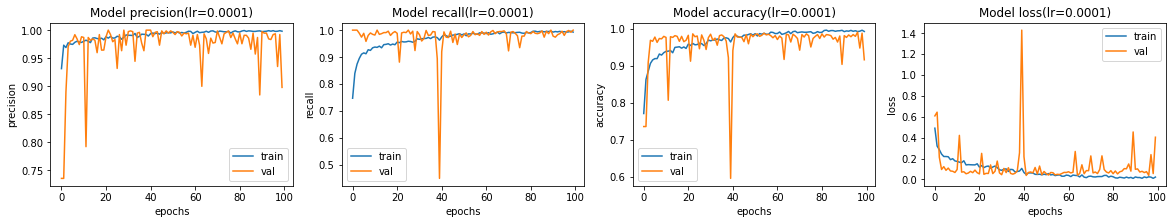

In [41]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()
history=metrics_lr[0]
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}(lr=0.0001)'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

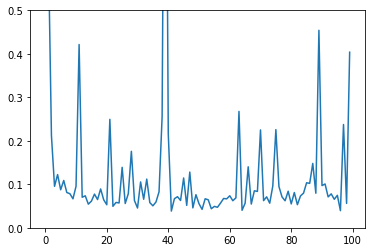

In [44]:
plt.plot(history.history["val_loss"])
plt.ylim(0,0.5)
plt.show()
print()

에포크가 42을 넘어가면서 validation loss가 다시 증가하는 것을 볼수 있다. 42 이후로는 학습하는 것이 큰 의미가 없어보이므로 42까지만 학습하기로 결정했다.

### Model1.(kernel size= (3,3), 필터개수 16개, dropout rate: 0.2, learning rate=1e-4, decay=1e-7)  + 원본 Data 

- Adam optimizer의 learning rate를 0.0001로 바꾸고 decay=0.0000001로 바꾸어서 돌려보았다.
- decay는 앞의 learning rate를 epoch이 진행되면서 차츰 learning rate를 줄여가는 것이다. 기본값은 0으로 되어있었으나, epoch이 증가하면서 갑자기 loss가 급격하게 증가했다가 줄어드는 현상을 보고 learning rate를 줄여가는 decay를 적용해보아야겠다고 생각했다.

In [23]:
EPOCHS=42

In [26]:
my_callbacks1= [
    tf.keras.callbacks.ModelCheckpoint(filepath='model1.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
with tf.device('/GPU:0'):
    model1 = build_model(filter1=16, kernel_size1=3, filter2=16, kernel_size2=3, dropout1=0.2, dropout2=0.2)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model1.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, decay=0.0000001),
        loss='binary_crossentropy',
        metrics=METRICS
    )
    history1 = model1.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=my_callbacks1
    )

Epoch 1/42
261/261 [==============================] - 61s 196ms/step - loss: 0.5002 - accuracy: 0.7447 - precision: 0.9466 - recall: 0.6960 - val_loss: 0.6495 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/42
261/261 [==============================] - 50s 192ms/step - loss: 0.3554 - accuracy: 0.8250 - precision: 0.9711 - recall: 0.7883 - val_loss: 0.5967 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/42
261/261 [==============================] - 50s 190ms/step - loss: 0.2940 - accuracy: 0.8640 - precision: 0.9767 - recall: 0.8369 - val_loss: 0.2341 - val_accuracy: 0.9596 - val_precision: 0.9763 - val_recall: 0.9686
Epoch 4/42
261/261 [==============================] - 51s 197ms/step - loss: 0.2490 - accuracy: 0.8877 - precision: 0.9793 - recall: 0.8676 - val_loss: 0.2726 - val_accuracy: 0.8644 - val_precision: 0.8444 - val_recall: 1.0000
Epoch 5/42
261/261 [==============================] - 53s 204ms/step - loss: 0.2357 - accura

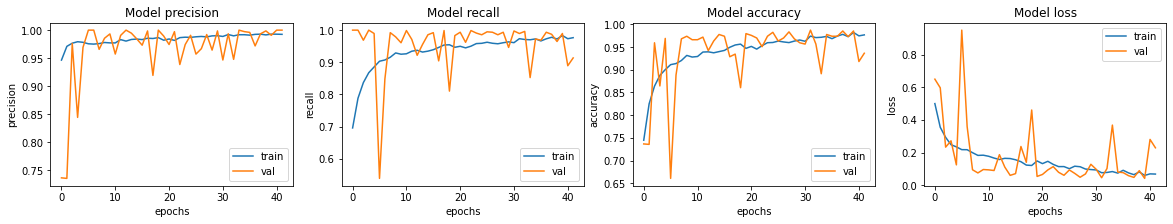

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history1.history[met])
    ax[i].plot(history1.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

validation accuracy가 가장 높은 모델을 선택한다. validation recall 역시 1에 가까워서 선택해도 괜찮을 것으로 여겨진다.

In [59]:
loss, accuracy, precision, recall = model1.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 126ms/step - loss: 0.4428 - accuracy: 0.8702 - precision: 0.8568 - recall: 0.9513
Loss: 0.44280922412872314,
Accuracy: 0.870192289352417,
Precision: 0.8568129539489746,
Recall: 0.9512820243835449


### 루브릭에 만족하는  accuracy가 0.87이 나왔다.
- decay를 적용해서 decay를 적용하기 전보다는 상대적으로 안정적으로 학습하였던 것 같다.decay 적용하기 전에는 학습에는 validation loss가 1 이상이 되었던 적도 있었다. 그에 비해서는 소폭으로 증가하는 것을 확인 할수 있었다.
- 하지만 프로젝트에서 권했던 
>1. Data argumentation을 적용하면 어떻게 되는지 체크해보고 싶고, 
>2. dropout을 0으로 했을 때 이 x-ray데이터가 어떻게 돌아가는지   

 체크하고 싶기 때문에 추가적인 모델을 더 돌려보고자 한다.
--------------------------------------------------------

### Model2.(kernel size= (3,3), 필터개수 16개, dropout rate: 0.2, learning rate=1e-4, decay=1e-7)  + Data argumentation

In [29]:
train_ds_ag = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE) 
val_ds_ag = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)


def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training_ag(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_ag = prepare_for_training_ag(train_ds_ag) 
val_ds_ag = prepare_for_training_ag(val_ds_ag)


In [30]:
my_callbacks2 = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model2.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),]

with tf.device('/GPU:0'):
    model2 = build_model(filter1=16, kernel_size1=3, filter2=16, kernel_size2=3, dropout1=0.2, dropout2=0.2)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model2.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, decay=0.0000001),
        loss='binary_crossentropy',
        metrics=METRICS
    )
    history2 = model2.fit(
        train_ds_ag,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_ag,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=my_callbacks2
    )

Epoch 1/42
261/261 [==============================] - 63s 209ms/step - loss: 0.5479 - accuracy: 0.6985 - precision: 0.9326 - recall: 0.6411 - val_loss: 0.9447 - val_accuracy: 0.2654 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/42
261/261 [==============================] - 49s 188ms/step - loss: 0.4018 - accuracy: 0.7924 - precision: 0.9670 - recall: 0.7461 - val_loss: 0.7494 - val_accuracy: 0.2644 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/42
261/261 [==============================] - 49s 188ms/step - loss: 0.3434 - accuracy: 0.8338 - precision: 0.9737 - recall: 0.7984 - val_loss: 0.3256 - val_accuracy: 0.8298 - val_precision: 0.8121 - val_recall: 1.0000
Epoch 4/42
261/261 [==============================] - 53s 203ms/step - loss: 0.3031 - accuracy: 0.8594 - precision: 0.9737 - recall: 0.8337 - val_loss: 0.1589 - val_accuracy: 0.9625 - val_precision: 0.9689 - val_recall: 0.9803
Epoch 5/42
261/261 [==============================] - 52s 198ms/step - loss:

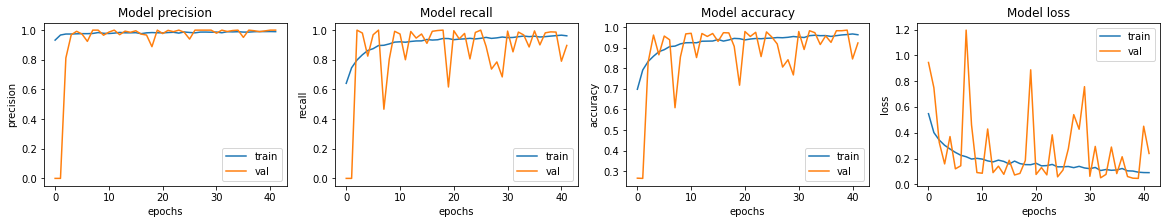

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [32]:
loss, accuracy, precision, recall = model2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 117ms/step - loss: 0.4111 - accuracy: 0.8558 - precision: 0.8409 - recall: 0.9487
Loss: 0.4110952615737915,
Accuracy: 0.8557692170143127,
Precision: 0.8409090638160706,
Recall: 0.9487179517745972


- Data argumentation을 하면 당연히 성능이 좋아질줄 알았으나 별로 그러지 않았다. 오히려 accuracy가 2% 떨어지고 loss도 불안정하게 떨어지는 것을 확인할 수 있었다.. 

### Model3. 원본 데이터에 filter=16, dropout =0.0

filter1=16, kernel_size1=3, filter2=16, kernel_size2=3, dropout1=0.0, dropout2=0.0 


In [33]:
my_callbacks3 = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model3.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),]

with tf.device('/GPU:0'):
    model3 = build_model(filter1=16, kernel_size1=3, filter2=16, kernel_size2=3, dropout1=0.0, dropout2=0.0)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model3.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, decay=0.0000001),
        loss='binary_crossentropy',
        metrics=METRICS
    )
    history3 = model3.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=my_callbacks3
    )

Epoch 1/42
261/261 [==============================] - 58s 189ms/step - loss: 0.4299 - accuracy: 0.7972 - precision: 0.9534 - recall: 0.7646 - val_loss: 0.5881 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/42
261/261 [==============================] - 53s 203ms/step - loss: 0.3086 - accuracy: 0.8561 - precision: 0.9772 - recall: 0.8261 - val_loss: 0.5952 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/42
261/261 [==============================] - 53s 203ms/step - loss: 0.2470 - accuracy: 0.9037 - precision: 0.9818 - recall: 0.8869 - val_loss: 0.5058 - val_accuracy: 0.7471 - val_precision: 0.7439 - val_recall: 1.0000
Epoch 4/42
261/261 [==============================] - 52s 201ms/step - loss: 0.2054 - accuracy: 0.9164 - precision: 0.9855 - recall: 0.9007 - val_loss: 0.0902 - val_accuracy: 0.9712 - val_precision: 0.9646 - val_recall: 0.9974
Epoch 5/42
261/261 [==============================] - 52s 198ms/step - loss: 0.1981 - accura

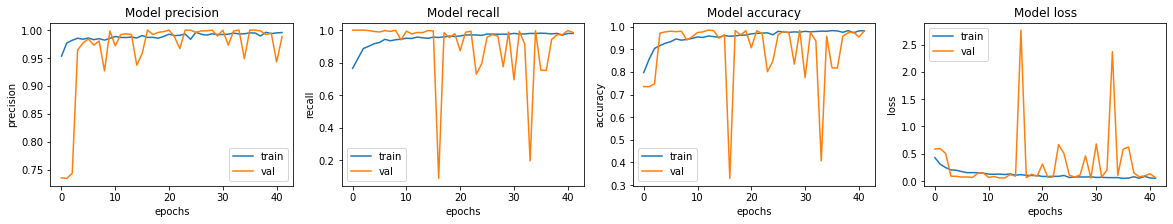

In [34]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history3.history[met])
    ax[i].plot(history3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [37]:
loss, accuracy, precision, recall = model3.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 118ms/step - loss: 1.2304 - accuracy: 0.7179 - precision: 0.6904 - recall: 0.9949
Loss: 1.2303965091705322,
Accuracy: 0.7179487347602844,
Precision: 0.690391480922699,
Recall: 0.9948717951774597


model1과 같은 조건에 dropout rate만 0으로 했다. 즉 dropout을 하지 않았다. __CS231N의 6강에서 Batch normalization을 하면 drop out을 굳히 할 필요는 없다__ 고 해서 dropout rate를 0으로 놓고 돌려보았다. 14%가량 accuracy가 떨어지는 것을 확인 할수 있었다. 데이터에 따라서 dropout과 batch normalization을 선택해서 적용하는게 좋을 것 같긴하지만 일단 이 __폐암 데이터셋은 dropout과 batch normalization을 모두 적용한 것이 성능이 더 좋아보인다.__ data argumentation을 추가한 데이터에서도 같은 경향을 보이는지 궁금해서 아래와 같이 모델을 돌려보았다. 

### Model4. (dropout 안한 모델)+data  argumentation

In [35]:
my_callbacks4 = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model4.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),]


with tf.device('/GPU:0'):
    model4 = build_model(filter1=16, kernel_size1=3, filter2=16, kernel_size2=3, dropout1=0.0, dropout2=0.0)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model4.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, decay=0.0000001),
        loss='binary_crossentropy',
        metrics=METRICS
    )
    history4 = model4.fit(
        train_ds_ag,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_ag,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=my_callbacks4)

Epoch 1/42
261/261 [==============================] - 59s 192ms/step - loss: 0.4660 - accuracy: 0.7534 - precision: 0.9410 - recall: 0.7133 - val_loss: 0.6154 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/42
261/261 [==============================] - 48s 186ms/step - loss: 0.3050 - accuracy: 0.8587 - precision: 0.9776 - recall: 0.8291 - val_loss: 0.7502 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/42
261/261 [==============================] - 49s 188ms/step - loss: 0.2702 - accuracy: 0.8827 - precision: 0.9756 - recall: 0.8637 - val_loss: 0.2584 - val_accuracy: 0.8817 - val_precision: 0.8613 - val_recall: 1.0000
Epoch 4/42
261/261 [==============================] - 53s 203ms/step - loss: 0.2534 - accuracy: 0.8975 - precision: 0.9789 - recall: 0.8813 - val_loss: 0.2461 - val_accuracy: 0.9154 - val_precision: 0.9971 - val_recall: 0.8874
Epoch 5/42
261/261 [==============================] - 50s 193ms/step - loss: 0.2294 - accura

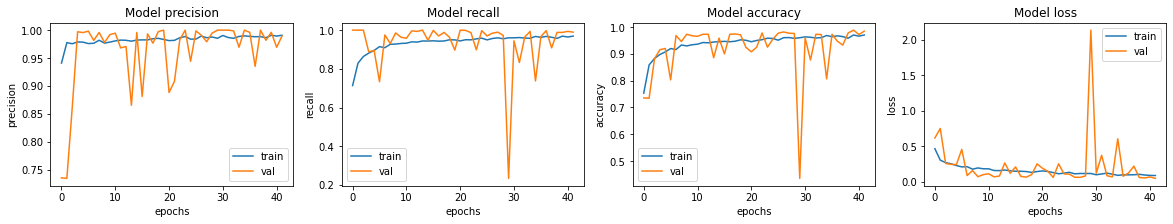

In [36]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history4.history[met])
    ax[i].plot(history4.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [38]:
loss, accuracy, precision, recall = model4.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 119ms/step - loss: 1.1636 - accuracy: 0.7131 - precision: 0.6861 - recall: 0.9974
Loss: 1.1635627746582031,
Accuracy: 0.7131410241127014,
Precision: 0.6860670447349548,
Recall: 0.9974358677864075


In [83]:
models={}
for idx,m in enumerate([model1, model2, model3, model4]):
    loss, accuracy, precision, recall = m.evaluate(test_ds)
    models["model%d"%(idx+1)]=[loss, accuracy, precision, recall]

39/39 [==============================] - 4s 109ms/step - loss: 1.1636 - accuracy: 0.7131 - precision: 0.6861 - recall: 0.9974


In [84]:
df=pd.DataFrame(models)
df["index"]=["loss","accuracy", "precision","recall"]
df=df.set_index("index",drop=True)
df

,model1,model2,model3,model4
index,,,,
loss,0.442809,0.411095,1.230397,1.163563
accuracy,0.870192,0.855769,0.717949,0.713141
precision,0.856813,0.840909,0.690391,0.686067
recall,0.951282,0.948718,0.994872,0.997436


In [95]:
import seaborn as sns

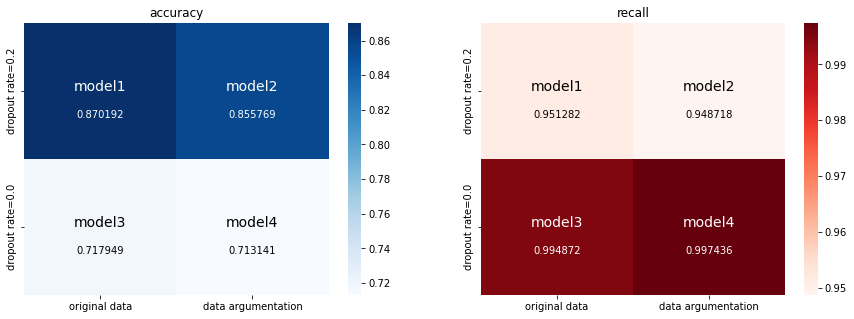

In [129]:
plt.figure(figsize=(15,5))
# accuray 
plt.subplot(1,2,1)
sns.heatmap(np.array(df.T["accuracy"]).reshape((2,2)), cmap="Blues")
plt.annotate('model1', xy=(0.5, 0.5), fontsize=14, ha='center',color="white")
plt.annotate('0.870192', xy=(0.5, 0.7), fontsize=10, ha='center',color="white")

plt.annotate('model2', xy=(1.5, 0.5), fontsize=14, ha='center',color="white")
plt.annotate('0.855769', xy=(1.5, 0.7), fontsize=10, ha='center',color="white")

plt.annotate('model3', xy=(0.5, 1.5), fontsize=14, ha='center')
plt.annotate('0.717949', xy=(0.5, 1.7), fontsize=10, ha='center')

plt.annotate('model4', xy=(1.5, 1.5), fontsize=14, ha='center')
plt.annotate('0.713141', xy=(1.5, 1.7), fontsize=10, ha='center')

plt.xticks([0.5,1.5],["original data","data argumentation"])
plt.yticks([0.5,1.5],["dropout rate=0.2", "dropout rate=0.0"])
plt.title("accuracy")

# recall 
plt.subplot(1,2,2)

sns.heatmap(np.array(df.T["recall"]).reshape((2,2)), cmap=plt.cm.Reds)
plt.annotate('model1', xy=(0.5, 0.5), fontsize=14, ha='center')
plt.annotate('0.951282', xy=(0.5, 0.7), fontsize=10, ha='center')

plt.annotate('model2', xy=(1.5, 0.5), fontsize=14, ha='center')
plt.annotate('0.948718', xy=(1.5, 0.7), fontsize=10, ha='center')

plt.annotate('model3', xy=(0.5, 1.5), fontsize=14, ha='center',color="white")
plt.annotate('0.994872', xy=(0.5, 1.7), fontsize=10, ha='center',color="white")

plt.annotate('model4', xy=(1.5, 1.5), fontsize=14, ha='center',color="white")
plt.annotate('0.997436', xy=(1.5, 1.7), fontsize=10, ha='center',color="white")

plt.xticks([0.5,1.5],["original data","data argumentation"])
plt.yticks([0.5,1.5],["dropout rate=0.2", "dropout rate=0.0"])
plt.title("recall")
plt.show()

### 모든 모델의 공통 사항  
- __optimizer:__  __Adam__ 을 썼고, __learning rate는 0.0001__, __decay는 0.0000001__ 이다.  
- __weight initialize__ : __xavier initialize__ 를 설정했고,  __normal distribution__ 에서 weight을 가져오도록 만들었다. 또한 각 kernel의 random seed를 걸어주어서 초기의 weight을 동일하게 시작하도록 만들었다. 다만 drop out을 하는 과정에서 랜덤하게 노드를 0으로 만들기 때문에 값이 결과는 당연히 각각 다를 것이다.

### 모델별 차이
- __data argumenatation__ 한 모델: model2, model4
- __dropout(0.2)__을 한 모델: model1, model2


### 결과   
- 특성상 폐암에 안걸린 사람을 폐암에 걸렸다고 오진하는 쪽이 폐암걸린 사람을 안 걸렸다고 하는 것보다는 낫기 때문에 __accuracy와 recall을 먼저 함께 봐야__ 한다고 생각해서 모델별 accuracy와 recall에 대한 heatmap 그래프를 함께 그렸다. 최종적으로 모델을 고를때 precision을 확인하고 고르려고 한다.

- 원본 데이터만 vs. 원본 데이터 + data argumentation    
: __원본 데이터로만 학습한 model1과 model3__ 이 data argumentation을 추가한 model2와 mode4에 비해    
    __accuracy__ 가 model1은 model2에 비해 1.5% 높고, model3은 model4에 비해 0.4%정도 높다.     
    __recall__ 은 mode1은 model2에 비해 0.3% 정도 높고, model3은 model4에 비해 0.3%정도 낮다.    

__data argumentation을 추가한 모델__ 이 원본으로만 학습한 모델에 비해서 __모델 정확도는 1% 안팎으로 감소__ 했고, recall은 1% 정도 높거나 낮아졌다. 이 정도는 모델의 성능에 큰 영향을 미쳤다고 보기는 어려운 것으로 생각이 들었다.   

- __dropout rate 0.2 vs.dropout rate 0.0(적용안함.)__  
: dropout rate를 0.2 정도 적용한 model1과 model2는 dropout을 적용하지 않은 model3과 model4와 비교하면   
__accuracy__ 는 model1은 model3에 비해서 16% 높고, model2는 model4에 비해 14% 높다.    
반면 __recall__ 은 model1이 model3에 비해서 4.3% 낮고, model2는 model4에 비해서 3.9%정도 낮다. 

__dropout을 적용한 모델__ 이 적용하지 않은 모델에 비해 __accuracy는 10% 이상 높고, recall은 4% 안팎으로 낮아졌다__ 


-----------------------------------------
### 회고

- CS231의 6강에서 learning rate를 너무 크게 잡으면 오버슈팅(over shooting)이 일어나고, 너무 작게 잡으면 학습이 잘 이루어지지 않는다는 것을 직접 확인해보고 싶어서 돌려보았다. 실제로 시도해본 $10^{-2},10^{-3},10^{-4},10^{-5}$ 중에서 $10^{-2},10^{-3}$ 이 $10^{-4},10^{-5}$에 비해서 loss의 학습곡선이 들쑥날쑥 올라가는 것을 $10^{-5}$은 validation loss의 학습곡선이 너무 느리게 감소하는 것을 확인할수 있었다. 
- 이렇게 선택한 learning rate $10^{-4}$의 에포크를 노드에서 주어진 에포크의 2배인 50으로 잡고 돌려보았다. 처음에는 꾸준히 loss가 감소했지만 40이후로는 오히려 loss가 증가하는 것을 관찰하여서 42로 정했다. 그리고 에포크가 늘어나니까 loss가 다시 삐죽삐죽 늘어나는 현상이 보여서 learning rate를 서서히 감소시키는 decay를 사용해보았고, 
- 실제로 model1,2,3,4에 decay를 적용해보았다. 사실 model1은 epoch를 40으로 줄인 것에 불과하고, decay를 적용시켰을때 어떻게 달라지는지를 보고 싶어서 돌려보았는데 loss가 갑자기 특정 에포크에서 뛰는 현상이 감소한 것으로 보아서 결과가 좋았다고 판단했다.
- data argumentation은 노드에서 주어진 좌우반전만 사용해서 그런지 모델의 성능이 많이 좋아졌다고 생각이 들지는 않았다. 다만 __dropout를 추가하니까 10% 정도 높은 accuracy를 보였다는 점__ 에서 효과적인 방법으로 생각된다. CS231에서 Batch normalization 혹은 dropout 둘 중에 하나만 쓰기를 권했으나 폐암데이터에서는 __batch normalization과 dropout을 함께 쓰는 쪽__ 이 오히려 성능이 좋게 나오는 것을 확인할 수 있었다. 모델에는 왕좌가 없듯이 테스트를 해봐야지 성능을 알수 있는 것 같다. 
- 처음에는 __accuracy가 가장 높은 model1__ 이 가장 좋은 모델이라고 처음에는 생각했으나 __의료 데이터 특성상 recall이 가장 높은 model4__ 가 accuracy는 낮지만 조금은 더 안전한 모델일 수는 있겠다고 생각을 했었다.
- 하지만  model1은 precision이 85.6%인데 model4는 precision이 68%라는 점에서 model4 모델을 크게 신뢰하기 힘들다고 여겨져서 아래와 같이 F1 score를 model1과 model4에 대해서 계산해보았다. model1의 F1 score 점수가 더 높았고 최종적으로 가장 좋은 모델은 model1이라고 판단을 내렸다.

In [3]:
# f1 scor는 accuracy,recall, precision 중 어느 하나만 보고 판단하기 어려울때 쓰는 점수이다.

def f1_score(recall, precision): 
    return 2*(recall*precision)/(recall+precision)

In [4]:
model1_precision, model4_precision=0.856813, 0.686067
model1_recall, model4_recall=0.951282, 0.997436

print("model1의 F1 score:",f1_score(model1_recall, model1_precision))
print("model4의 F1 score:",f1_score(model4_recall, model4_precision))

model1의 F1 score: 0.901579600923624
model4의 F1 score: 0.8129571782313425
